In [1]:
from pivpy import io
from pivpy import graphics
import xarray as xr
import numpy as np

import pkg_resources as pkg

In [2]:
# read the arrays
filename = pkg.resource_filename('pivpy','data/VC7/2Ca.VC7')
data = io.load_vc7(filename)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa788bb2a90>)

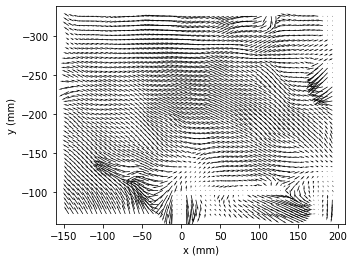

In [3]:
graphics.quiver(data,arrScale=10)

In [4]:
# we created a shortcut to the above cells in pivpy.io
data = io.load_vc7('../../tests/data/2Cb.VC7')

OSError: file not found ../../tests/data/2Cb.VC7

In [ ]:
graphics.quiver(data,arrScale=10)